# COVID lesion segmentation with CT images (using PyTorch and the monai library)

## Installing the dependencies and downloading the CT images

In [1]:
!pip install -r requirements.txt -q
!chmod +x download_data.sh
!bash download_data.sh

     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 23.9 MB/s 
     |████████████████████████████████| 376 kB 39.7 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
Downloading...
From: https://docs.google.com/uc?export=download&id=1WYyy67rXuT3jimOnD2PeFKwIT7efGp6n
To: /content/COVID-19-20.zip
100% 4.63G/4.63G [00:28<00:00, 163MB/s]


## Importing the relevant libraries

In [2]:
# import libraries
from platform import architecture
import re, random, torch, cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import numpy as np
import gc
import torchvision

from glob import glob
from cv2 import imread
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate,
    ScaleIntensityd,
    EnsureTyped,
    Orientationd,
    RandAffined,
    RandRotate90d,
    RandRotated,
    RandGaussianNoised
    )

## Creating the data splits from the raw data

In [3]:
def custom_collate(batch):
    images = torch.cat([torch.as_tensor(np.transpose(item_["img"], (3, 0, 1, 2))) for item in batch for item_ in item], 0).contiguous()
    segs = torch.cat([torch.as_tensor(np.transpose(item_["seg"], (3, 0, 1, 2))) for item in batch for item_ in item], 0).contiguous()
    
    return [images, segs]

def create_data_splits(train_split, test_split):
    # get path to all volumes
    images = sorted(glob("images/*_ct.nii.gz"))

    random.seed(2022)
    train_images = random.sample(images, int(train_split * len(images)))
    val_images = list(set(images) - set(train_images))
    test_images = random.sample(val_images, int(test_split * len(images)))
    val_images = list(set(val_images) - set(test_images))
    
    train_segs = [img.replace("ct", "seg") for img in train_images]
    val_segs = [img.replace("ct", "seg") for img in val_images]
    test_segs = [img.replace("ct", "seg") for img in test_images]
    
    train_files = [{"img": img, "seg": seg} for img, seg in zip(train_images, train_segs)]
    val_files = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_segs)]
    test_files = [{"img": img, "seg": seg} for img, seg in zip(test_images, test_segs)]

    return train_files, val_files, test_files

## Defining the training algorithm with the use of an FPN model

In [4]:
def train_model(train_loader, valid_loader):
    
    model = smp.FPN(encoder_name = "resnet34",
                classes = 1,
                encoder_weights = "imagenet",
                in_channels = 1,
                activation = "sigmoid",
                decoder_dropout = 0.2)

    loss = utils.losses.DiceLoss()

    metrics = [
        utils.metrics.IoU(threshold = 0.5)
    ]

    optimizer = torch.optim.Adam([dict(params = model.parameters(), lr = 1e-4)])
    
    train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss = loss,
        metrics = metrics,
        optimizer = optimizer,
        device = "cuda",
        verbose = True)

    valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss = loss,
        metrics = metrics,
        device = "cuda",
        verbose = True)

    # train model for 20 epochs
    epochs = 20
    max_score = 0
    
    for i in range(epochs):

        print("\nEpoch: {}".format(i + 1))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)
        
        # do save model
        if max_score < valid_logs["iou_score"]:
            max_score = valid_logs["iou_score"]
            torch.save(model.state_dict(), "best_model.pth")

## Preparing the training process

/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


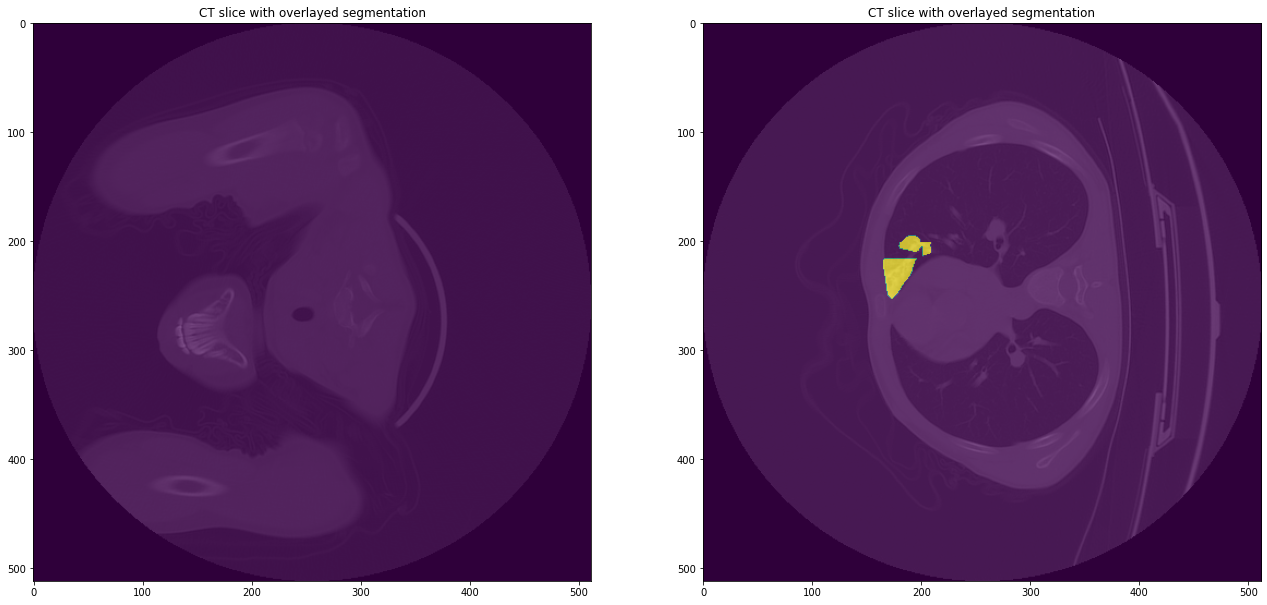

In [5]:
# augmentation
transforms = Compose(
    [
      LoadImaged(keys = ["img", "seg"]),
      AddChanneld(keys = ["img", "seg"]),
      ScaleIntensityd(keys = ["img", "seg"]),
      RandCropByPosNegLabeld(
      keys = ["img", "seg"], label_key = "seg", spatial_size = [512, 512, 1], pos = 2, neg = 1, num_samples = 8),
      EnsureTyped(keys = ["img", "seg"])
      ])

# clear cache
gc.collect()
torch.cuda.empty_cache()

# run model
best_score = 0.0
train_split = 0.7
test_split = 0.1
batch_size = 2
train_files, val_files, test_files = create_data_splits(train_split, test_split)

# create a training data loader
train_ds = monai.data.Dataset(data = train_files, transform = transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True,
  num_workers = 2, collate_fn = custom_collate, pin_memory = torch.cuda.is_available())

# create a validation data loader
val_ds = monai.data.Dataset(data = val_files, transform = transforms)
val_loader = DataLoader(val_ds, batch_size = batch_size, num_workers = 2, shuffle = False, 
                        collate_fn = custom_collate)

# create a test data loader
test_ds = monai.data.Dataset(data = test_files, transform = transforms)
test_loader = DataLoader(test_ds, batch_size = batch_size, num_workers = 2, shuffle = False, 
                         collate_fn = custom_collate)    

# visualize a batch of training data
images, labels = next(iter(train_loader))

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(22, 22)

for i in range(2):
  axs[i].imshow(images[i][0, :, :], cmap = "gray")
  axs[i].imshow(labels[i][0, :, :], alpha = 0.7)
  axs[i].set_title("CT slice with overlayed segmentation")

## Training the model

In [6]:
# train the model
train_model(train_loader = train_loader, valid_loader = val_loader)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]


Epoch: 1
valid: 100%|██████████| 21/21 [00:47<00:00,  2.26s/it, dice_loss - 0.6416, iou_score - 0.237]

Epoch: 2
valid: 100%|██████████| 21/21 [00:47<00:00,  2.27s/it, dice_loss - 0.5353, iou_score - 0.3177]

Epoch: 3
valid: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it, dice_loss - 0.4765, iou_score - 0.3689]

Epoch: 4
valid: 100%|██████████| 21/21 [00:47<00:00,  2.26s/it, dice_loss - 0.4774, iou_score - 0.3776]

Epoch: 5
valid: 100%|██████████| 21/21 [00:47<00:00,  2.27s/it, dice_loss - 0.4131, iou_score - 0.4297]

Epoch: 6
valid: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it, dice_loss - 0.3959, iou_score - 0.4488]

Epoch: 7
valid: 100%|██████████| 21/21 [00:47<00:00,  2.24s/it, dice_loss - 0.3747, iou_score - 0.4749]

Epoch: 8
valid: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it, dice_loss - 0.3475, iou_score - 0.502]

Epoch: 9
valid: 100%|██████████| 21/21 [00:46<00:00,  2.22s/it, dice_loss - 0.3638, iou_score - 0.4818]

Epoch: 10
valid: 100%|██████████| 21/21 [00:47<00:00,  2

## Load best model and do some inference with it

In [7]:
model = smp.FPN(encoder_name = "resnet34",
                classes = 1,
                encoder_weights = "imagenet",
                in_channels = 1,
                activation = "sigmoid",
                decoder_dropout = 0.2)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
  scores = []
  img = []
  ground_truth = []
  pred_mask = []

  for image, mask in test_loader:
    pred = model(image)

    for i in range(len(image)):
      target = mask[i, :, :, :]
      pr_mask = pred[i, :, :, :]

      if target.max() > 0:
        temp_score = smp.utils.metrics.IoU().forward(pr_mask, target)
        scores.append(temp_score.numpy())
        img.append(image[i, :, :, :])
        ground_truth.append(target)
        pred_mask.append(pr_mask)

### The three best mask predictions based on IoU score

[111 107  94]


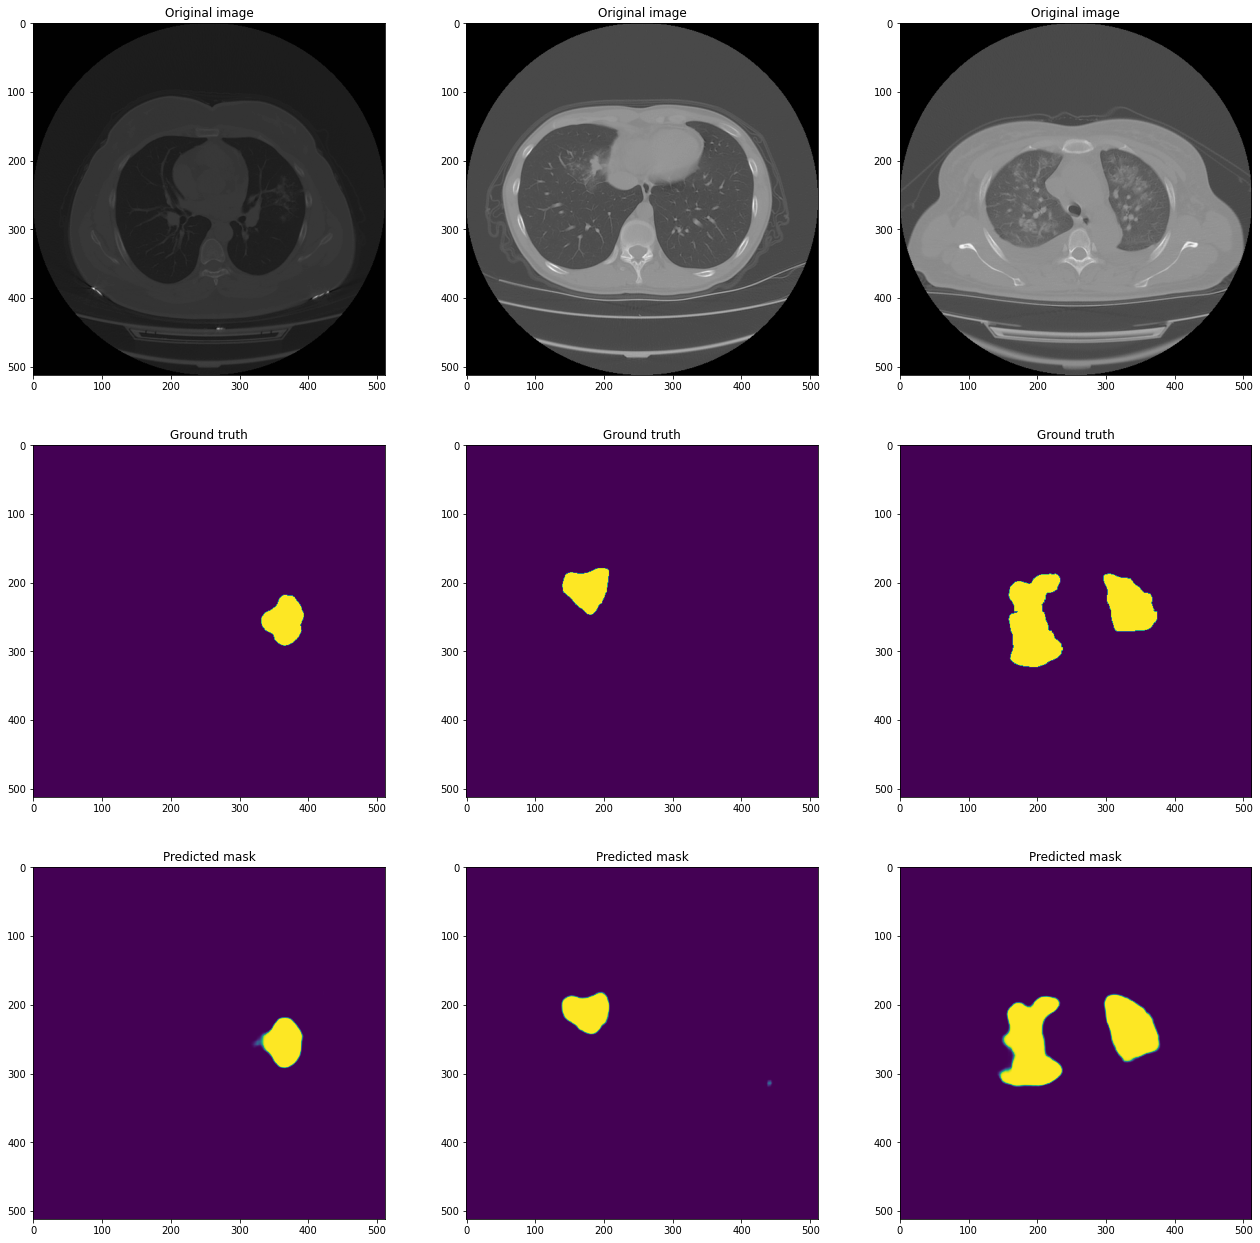

In [8]:
max_values = np.argsort(scores)[-3:]

print(max_values)

max_img = [img[i] for i in range(len(img)) if i in max_values]
max_ground_truth = [ground_truth[i] for i in range(len(ground_truth)) if i in max_values]
max_pred_mask = [pred_mask[i] for i in range(len(pred_mask)) if i in max_values]

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(22, 22)

for i in range(len(max_values)):
    image = max_img[i]
    truth = max_ground_truth[i]
    mask = max_pred_mask[i]
    # image
    ax[0][i].imshow(np.transpose(image)[:, :, 0], cmap = "gray")
    ax[0][i].set_title("Original image")

    # truth
    ax[1][i].imshow(np.transpose(truth)[:, :, 0])
    ax[1][i].set_title("Ground truth")

    # pred
    ax[2][i].imshow(np.transpose(mask.detach())[:, :, 0])
    ax[2][i].set_title("Predicted mask")

### The three worst mask predictions based on IoU score

[ 21 100  98]


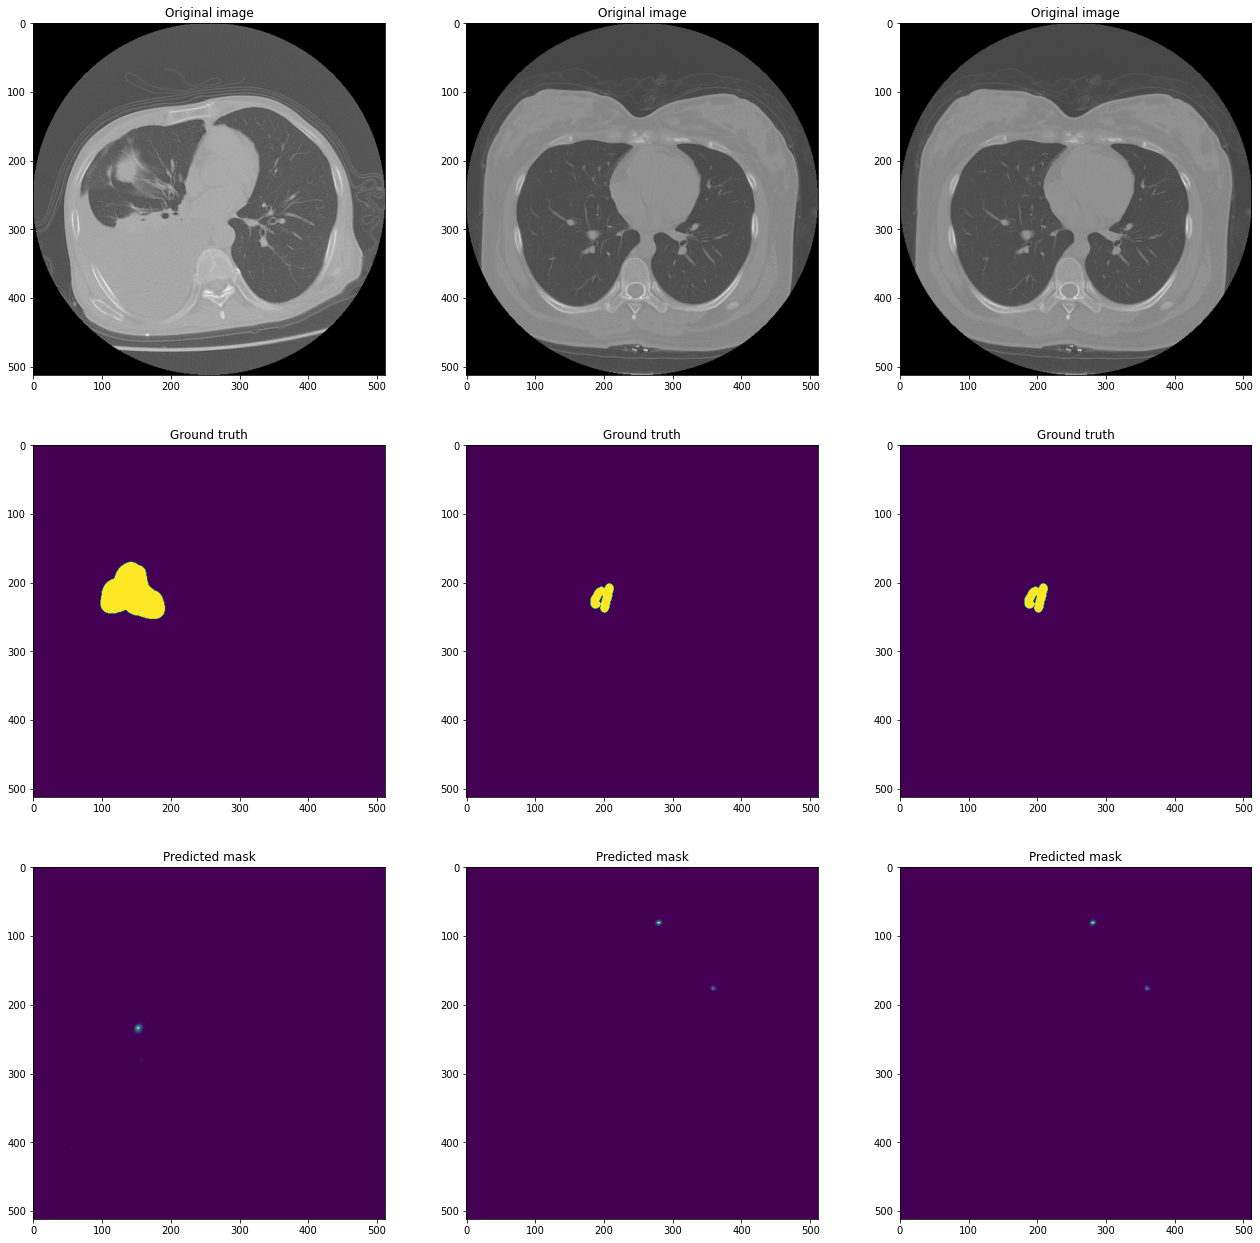

In [9]:
min_values = np.argsort(scores)[:3]
print(min_values)

min_img = [img[i] for i in range(len(img)) if i in min_values]
min_ground_truth = [ground_truth[i] for i in range(len(ground_truth)) if i in min_values]
min_pred_mask = [pred_mask[i] for i in range(len(pred_mask)) if i in min_values]

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(22, 22)

for i in range(len(min_values)):
    image = min_img[i]
    truth = min_ground_truth[i]
    mask = min_pred_mask[i]
    # image
    ax[0][i].imshow(np.transpose(image)[:, :, 0], cmap = "gray")
    ax[0][i].set_title("Original image")

    # truth
    ax[1][i].imshow(np.transpose(truth)[:, :, 0])
    ax[1][i].set_title("Ground truth")

    # pred
    ax[2][i].imshow(np.transpose(mask.detach())[:, :, 0])
    ax[2][i].set_title("Predicted mask")